In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

### 3-layer neural network

Our dataset contains several 2D points:

In [2]:
data = np.array([[ 1.2, 0.7],
                 [-0.3,-0.5],
                 [ 3.0, 0.1],
                 [-0.1,-1.0],
                 [-0.0, 1.1],
                 [ 2.1,-1.3],
                 [ 3.1,-1.8],
                 [ 1.1,-0.1],
                 [ 1.5,-2.2],
                 [ 4.0,-1.0]])

labels = np.array([  1,
                    -1,
                     1,
                    -1,
                    -1,
                     1,
                    -1,
                     1,
                    -1,
                    -1])

In [3]:
def plot_data(data, labels):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.scatter(data[:,0], data[:,1], c=labels, s=50,  cmap=plt.cm.bwr,zorder=50)
    nudge = 0.08
    for i, d in enumerate(data):
        ax.annotate(f'{i}',(d[0]+nudge,d[1]+nudge))
    ax.set_aspect('equal', 'datalim')
    plt.show()

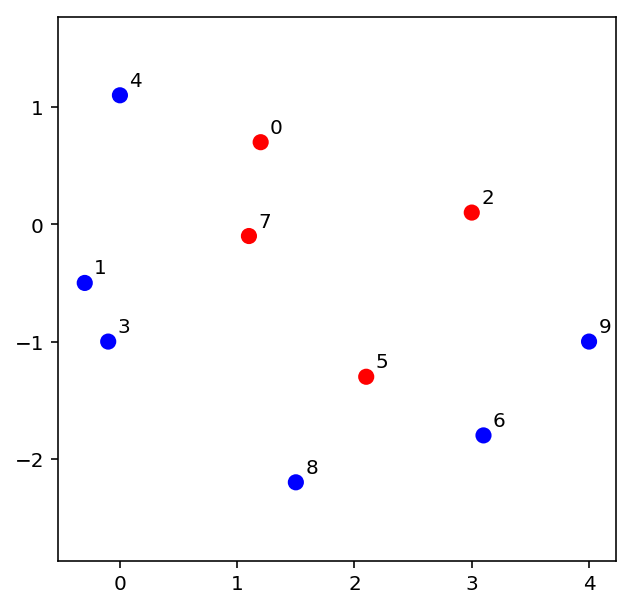

In [4]:
plot_data(data, labels)

This is the neural network's architecture:

<img src="img/neural_networks_23.png" alt="drawing" width="650"/>

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def create_meshgrid(data):
    h = 0.02
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return (xx,yy,np.ones(xx.shape))

def eval_accuracy_neural(params, data, labels):
    A1, A2, A3, B1, B2, B3, C1, C2, C3 = params
    num_correct = 0;
    data_len = len(data)
    
    for (X,Y), true_label in zip(data, labels):
        output = A3*sigmoid(A1*X + B1*Y + C1) + B3*sigmoid(A2*X + B2*Y + C2) + C3
        predicted_label = 1 if output > 1 else -1 if output < -1 else 0
        
        if (predicted_label == true_label):
            num_correct += 1
    return num_correct / data_len

def plot_neural_simple(params, grid,data, labels, iteration, accuracy):
    nudge = 0.06
    A1, A2, A3, B1, B2, B3, C1, C2, C3 = params
    xx,yy,Z = grid
    
    for i in range(xx.shape[0]): # row
        for j in range(yy.shape[1]): #column
            X, Y = xx[i][j],yy[i][j]
            output = A3*sigmoid(A1*X + B1*Y + C1) + B3*sigmoid(A2*X + B2*Y + C2) + C3
            predicted_label = 1 if output > 1 else -1 if output < -1 else 0
            Z[i][j] = predicted_label

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    plt.title(f'accuracy at the iteration {iteration}: {accuracy}')
    ax.contourf(xx, yy, Z, cmap=plt.cm.binary, alpha=0.1, zorder=15)
    ax.scatter(data[:, 0], data[:, 1], c=labels, s=50,  cmap=plt.cm.bwr,zorder=50)
    ax.set_aspect('equal')
    for i, d in enumerate(data):
        ax.annotate(f'{i}',(d[0]+nudge,d[1]+nudge))
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

The algorithm:

In [6]:
def train_neural_network(data, labels, step_size, no_loops, iter_info):
    rnd = np.random.normal(size=9)

    # hidden layer neuron 1
    A1 = rnd[0] #weight for X
    B1 = rnd[1] #weight for Y
    C1 = rnd[2] #bias

    # hidden layer neuron 2
    A2 = rnd[3] #weight for X
    B2 = rnd[4] #weight for Y
    C2 = rnd[5] #bias

    # output layer neuron
    A3 = rnd[6] #weight for n1
    B3 = rnd[7] #weight for n2
    C3 = rnd[8] # bias
    
    grid = create_meshgrid(data)

    for i in range(no_loops):
        # get a single random data point
        index = np.random.randint(data.shape[0])
        # get X, Y of that data point and its label
        X,Y = data[index]
        label = labels[index]

        # forward pass
        N1 = sigmoid(A1*X + B1*Y + C1) # 1st neuron
        N2 = sigmoid(A2*X + B2*Y + C2) # 2nd neuron
        S = A3*N1 + B3*N2 + C3 # final activation

        sign = 1 if (label == 1 and S < 1) else -1 if (label == -1 and S > -1) else 0

        # backpropagating through the network
        # partial derivatives of the neuron s
        dA3, dB3, dC3 = N1, N2, 1
        # partial derivatives of the neuron n1
        dz1 = A3*N1*(1-N1)
        dA1, dB1, dC1 = dz1*X, dz1*Y, dz1
        # partial derivatives of the neuron n2
        dz2 = B3*N2*(1-N2)
        dA2, dB2, dC2 = dz2*X, dz2*Y, dz2
        
        # finally, do the parameter update
        A1 += sign * dA1 * step_size
        B1 += sign * dB1 * step_size
        C1 += sign * dC1 * step_size
        A2 += sign * dA2 * step_size
        B2 += sign * dB2 * step_size
        C2 += sign * dC2 * step_size
        A3 += sign * dA3 * step_size
        B3 += sign * dB3 * step_size
        C3 += sign * dC3 * step_size
        
        params = A1, A2, A3, B1, B2, B3, C1, C2, C3
        
        if (i%iter_info==0):
            accuracy = eval_accuracy_neural(params,data,labels)
            plot_neural_simple(params,grid, data, labels, i, accuracy)
        
    return (A1, A2, A3, B1, B2, B3, C1, C2, C3)

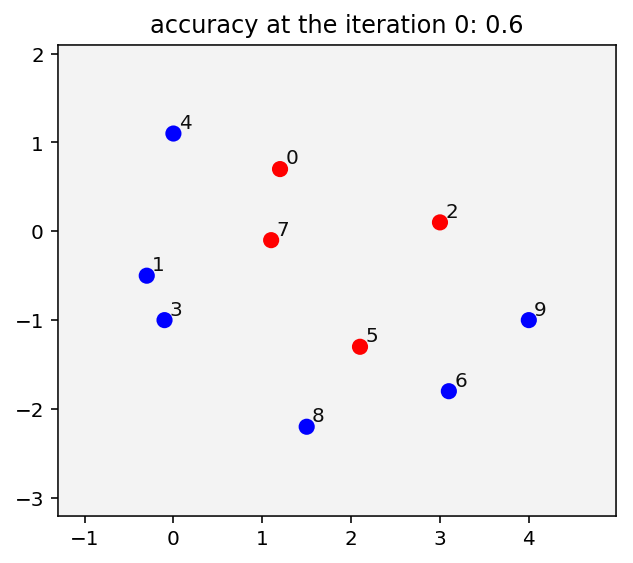

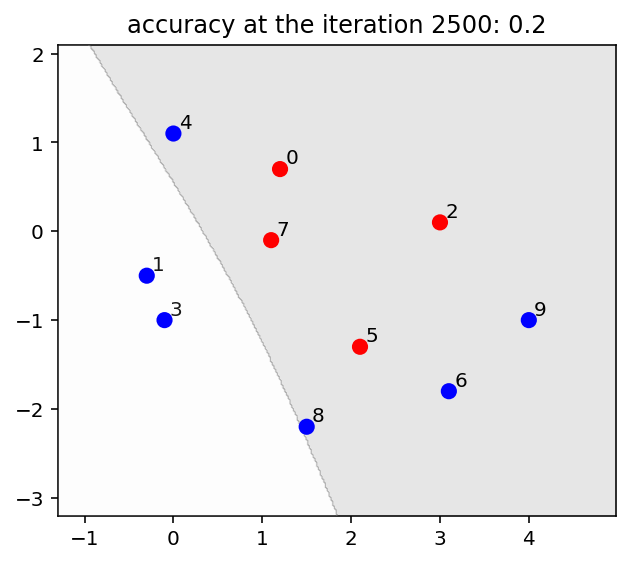

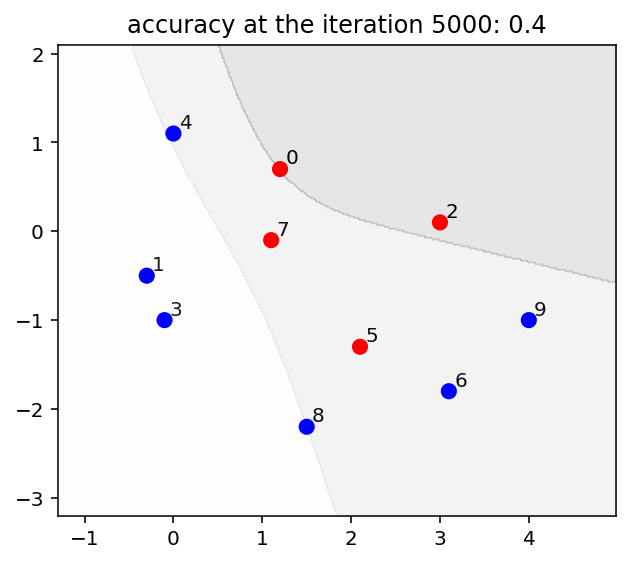

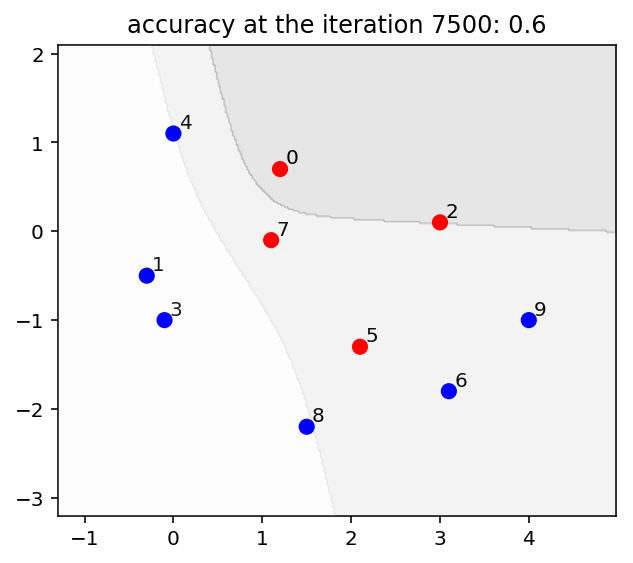

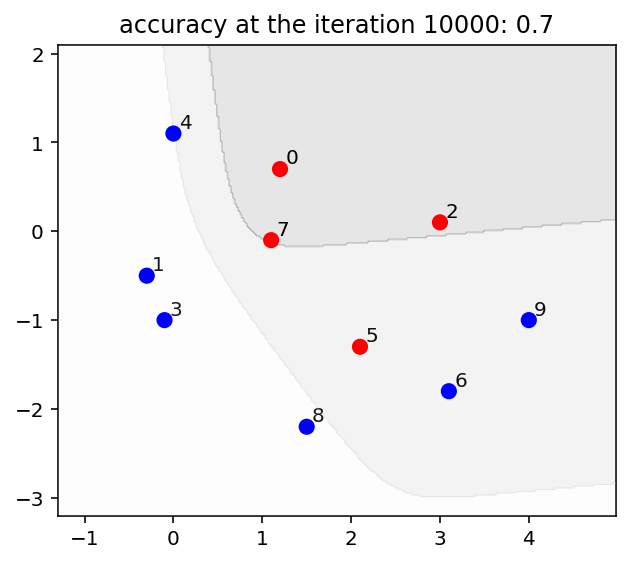

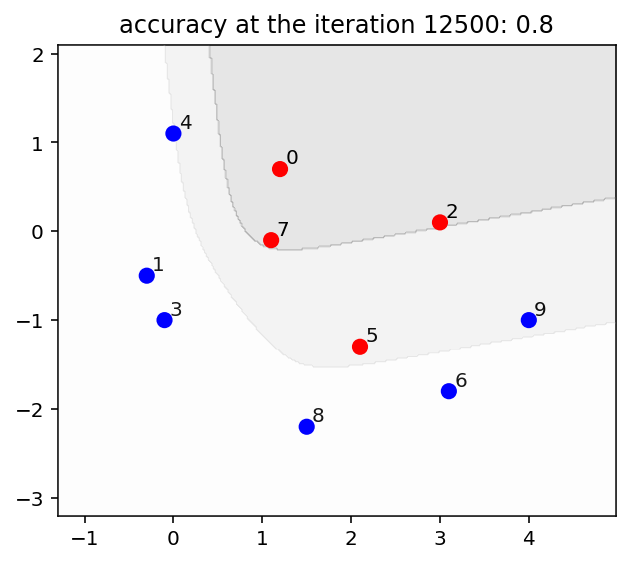

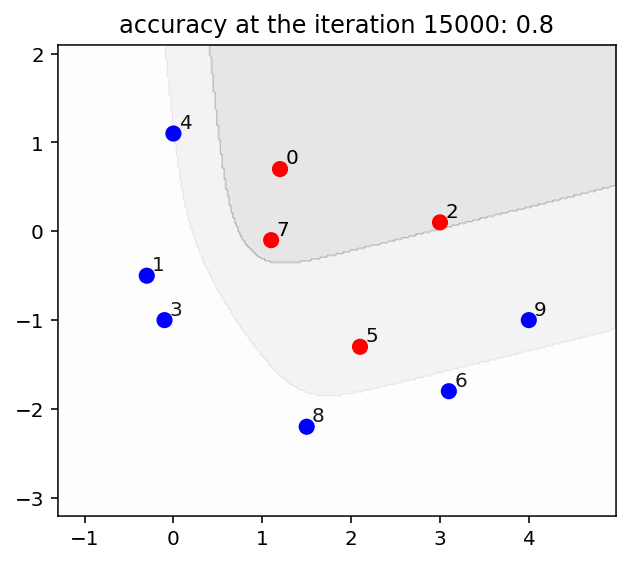

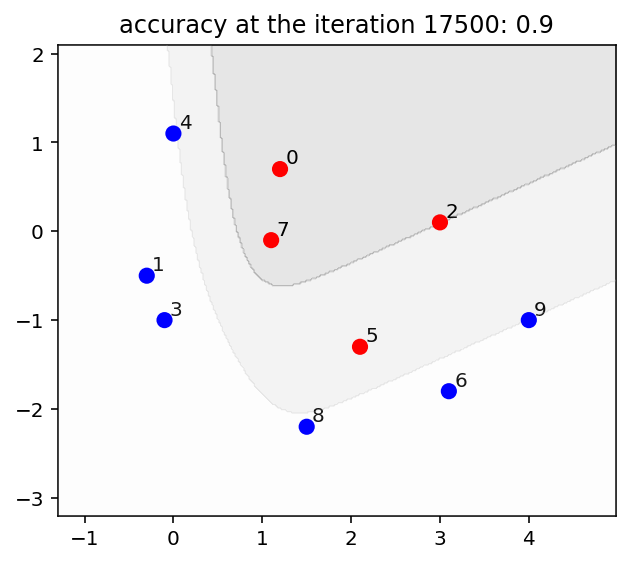

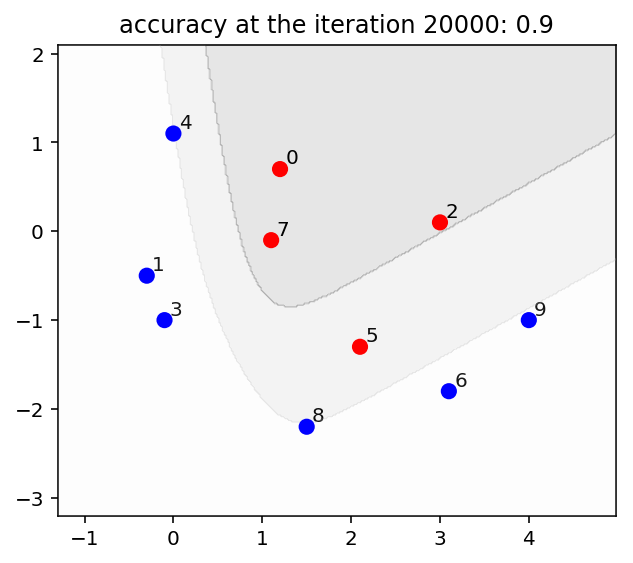

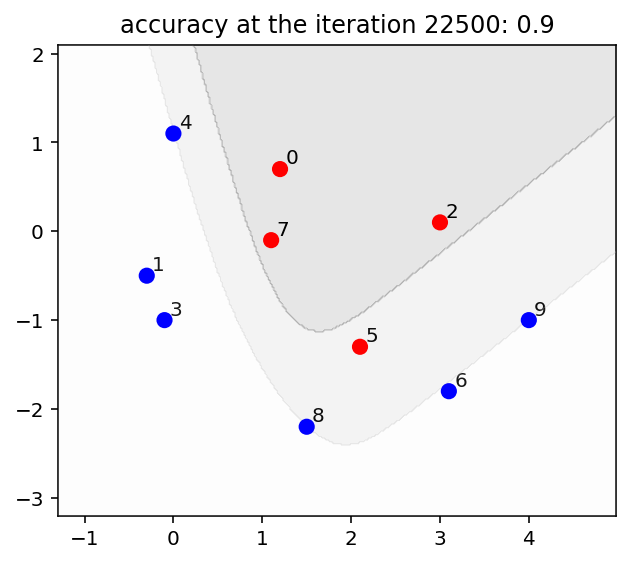

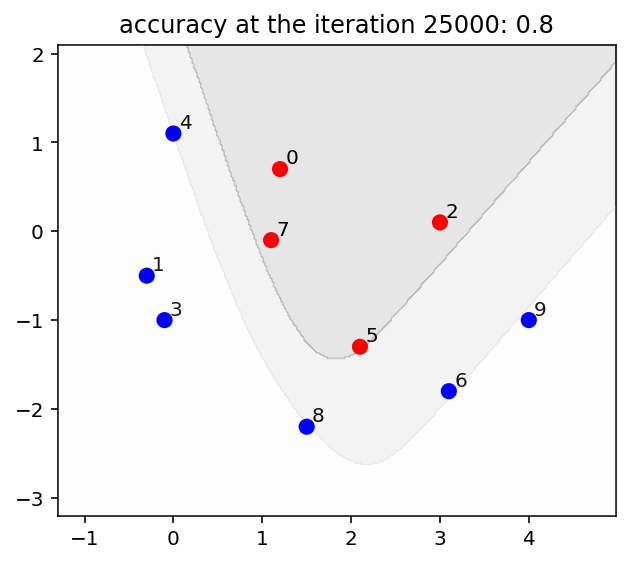

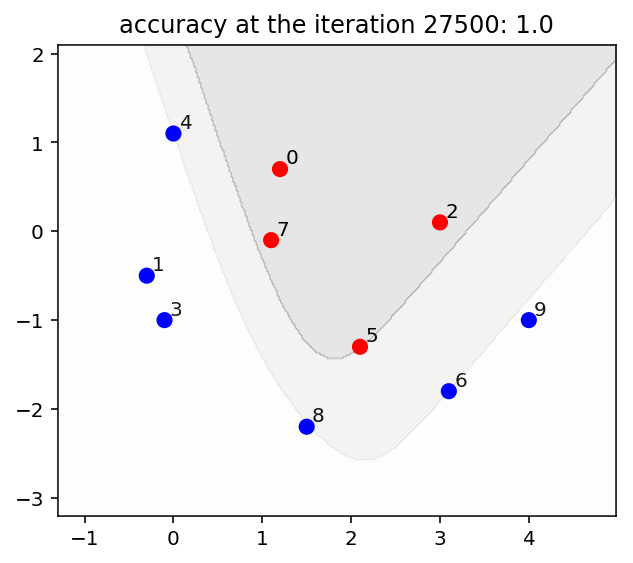

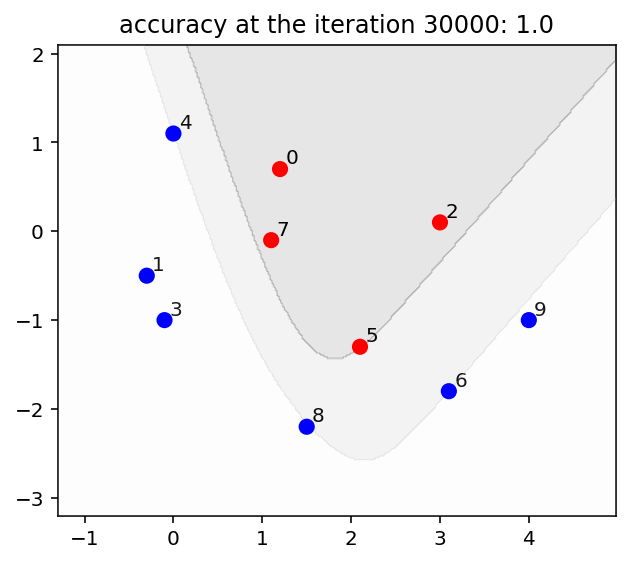

In [7]:
train = train_neural_network(data, labels, 0.01, 30001, 2500)

In [8]:
A1,A2,A3,B1,B2,B3,C1,C2,C3 = train
for i, ((X,Y), label) in enumerate(zip(data, labels)):
    output = A3*sigmoid(A1*X + B1*Y + C1) + B3*sigmoid(A2*X + B2*Y + C2) + C3
    predicted_label = 1 if output > 1 else -1 if output < -1 else 0
    print (f'''data point {i}: real label : {label}, pred. label: {predicted_label}, prediction correct: {(label==predicted_label)}''')

data point 0: real label : 1, pred. label: 1, prediction correct: True
data point 1: real label : -1, pred. label: -1, prediction correct: True
data point 2: real label : 1, pred. label: 1, prediction correct: True
data point 3: real label : -1, pred. label: -1, prediction correct: True
data point 4: real label : -1, pred. label: -1, prediction correct: True
data point 5: real label : 1, pred. label: 1, prediction correct: True
data point 6: real label : -1, pred. label: -1, prediction correct: True
data point 7: real label : 1, pred. label: 1, prediction correct: True
data point 8: real label : -1, pred. label: -1, prediction correct: True
data point 9: real label : -1, pred. label: -1, prediction correct: True


#### Exercise 1:
Update the previous example by updating the output neuron and implementing the MSE cost function:

<img src="img/neural_networks_25c.png" alt="drawing" width="900"/>